# Library imports

In [1]:
# Python standard library imports
import os
import shutil
from pathlib import Path
from typing import Any

# External libraries
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
from collections import defaultdict

# TensorFlow/Keras imports
from keras import Input, Model, Sequential
from keras.callbacks import CSVLogger, LearningRateScheduler
from keras.losses import CategoricalCrossentropy
from keras.metrics import AUC, CategoricalAccuracy, F1Score
from keras.optimizers import SGD
from keras.utils import image_dataset_from_directory
from keras.layers import (
    Rescaling, RandomBrightness, RandomFlip, RandomRotation, RandomZoom,
    RandomGaussianBlur, RandomErasing, RandomContrast, RandomTranslation,
    Conv2D, MaxPooling2D, Flatten, Dropout, Dense
)

# TensorFlow specific (avoiding duplication with Keras)
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import GaussianNoise

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from collections import defaultdict
import random
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras import layers, callbacks, optimizers

In [14]:
tf.config.threading.set_intra_op_parallelism_threads(2)
tf.config.threading.set_inter_op_parallelism_threads(2)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=4096)]  # em MB
    )


# EDA

In [3]:
df = pd.read_csv("rare_species/metadata.csv")
df['file_path'] = df['file_path'].apply(lambda x: Path("rare_species") / x)

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

data_dir_path = Path("data")

train_dir_path = data_dir_path / "train"
val_dir_path = data_dir_path / "val"
test_dir_path = data_dir_path / "test"
train_aug_dir = data_dir_path / "train_aug"
train_aug_dir.mkdir(exist_ok=True)

train_ds_original = tf.keras.utils.image_dataset_from_directory(
    train_dir_path,
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=1
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir_path,
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir_path,
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

def model_evaluate(model):
    print("\nAvaliação no teste:")
    model.evaluate(test_ds)

augmentation_pipeline = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.15),  # Aumentado para 15%
    layers.RandomZoom((-0.1, 0.2)),  # Permite zoom out
    layers.RandomContrast(0.15),
    layers.GaussianNoise(0.01),  # Adiciona pequeno ruído
])

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

Found 8388 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
Found 1798 files belonging to 202 classes.


Found 16 files belonging to 3 classes.


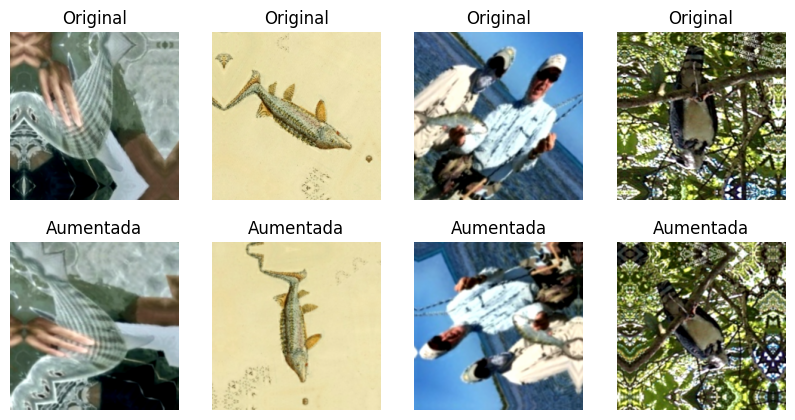

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.15),  # Aumentado para 15%
    layers.RandomZoom((-0.1, 0.2)),  # Permite zoom out
    layers.RandomContrast(0.15),
    layers.GaussianNoise(0.01),  # Adiciona pequeno ruído
])

# Aplicar ao dataset de treino
train_ds = train_ds_original.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Pegue um batch de exemplo
for images, _ in train_ds.take(1):
    # Aplique augmentations
    augmented_images = data_augmentation(images, training=True)
    
    # Mostre imagens originais vs aumentadas
    plt.figure(figsize=(10, 5))
    for i in range(4):
        plt.subplot(2, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Original")
        plt.axis("off")
        
        plt.subplot(2, 4, i+5)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.title("Aumentada")
        plt.axis("off")
    plt.show()

CLASS IMBALANCES

In [5]:
def count_class(path, output= False):
    class_counts = defaultdict(int)
    for class_dir in path.iterdir():
        if class_dir.is_dir():
            class_name = class_dir.name
            num_images = len(list(class_dir.glob('*')))
            class_counts[class_name] = num_images
    
    total_images = sum(1 for file in path.rglob('*') 
                  if file.is_file() and file.suffix.lower() in ['.jpg', '.jpeg', '.png'])

    print(f"Total de imagens em {path}: {total_images}")
    print("Contagem por classe:", dict(class_counts))
    if(output):
        return class_counts

class_counts = count_class(train_dir_path, True)

Total de imagens em data\train: 8388
Contagem por classe: {'accipitridae': 83, 'acipenseridae': 63, 'acroporidae': 147, 'agamidae': 42, 'agariciidae': 84, 'albulidae': 21, 'alcedinidae': 21, 'alligatoridae': 21, 'alopiidae': 42, 'ambystomatidae': 42, 'anatidae': 126, 'anguidae': 42, 'aotidae': 42, 'apidae': 105, 'ardeidae': 42, 'arthroleptidae': 21, 'atelidae': 105, 'attelabidae': 21, 'balaenicipitidae': 21, 'balaenidae': 21, 'balaenopteridae': 21, 'balistidae': 42, 'bombycillidae': 21, 'bovidae': 168, 'brachypteraciidae': 21, 'bucerotidae': 147, 'bufonidae': 105, 'burhinidae': 42, 'cacatuidae': 21, 'callitrichidae': 84, 'callorhinchidae': 21, 'caprimulgidae': 21, 'carabidae': 42, 'carcharhinidae': 189, 'cardiidae': 42, 'carettochelyidae': 21, 'cebidae': 63, 'cerambycidae': 21, 'cercopithecidae': 210, 'cervidae': 21, 'cetorhinidae': 21, 'chaetodontidae': 42, 'chamaeleonidae': 40, 'charadriidae': 42, 'cheirogaleidae': 21, 'chelidae': 40, 'cheloniidae': 21, 'chelydridae': 21, 'ciconiidae

Teste Oversampling

In [7]:
simple_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),  # Apenas horizontal
    layers.RandomRotation(0.05),     # ~18 graus
    layers.RandomZoom(0.1),         # Apenas zoom in
    layers.RandomContrast(0.1),
], name='simple_augmentation')

strong_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),    # ~29 graus
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.15),
    layers.RandomBrightness(0.1),  # Adicionei brightness
], name='strong_augmentation')

In [8]:
minority_classes = [cls.strip().lower() for cls, count in class_counts.items() if count < 50]

class_names = [name.strip().lower() for name in train_ds_original.class_names]

minority_class_indices = {
    i for i, name in enumerate(class_names) if name in minority_classes}

print(minority_classes)

['agamidae', 'albulidae', 'alcedinidae', 'alligatoridae', 'alopiidae', 'ambystomatidae', 'anguidae', 'aotidae', 'ardeidae', 'arthroleptidae', 'attelabidae', 'balaenicipitidae', 'balaenidae', 'balaenopteridae', 'balistidae', 'bombycillidae', 'brachypteraciidae', 'burhinidae', 'cacatuidae', 'callorhinchidae', 'caprimulgidae', 'carabidae', 'cardiidae', 'carettochelyidae', 'cerambycidae', 'cervidae', 'cetorhinidae', 'chaetodontidae', 'chamaeleonidae', 'charadriidae', 'cheirogaleidae', 'chelidae', 'cheloniidae', 'chelydridae', 'coenagrionidae', 'columbidae', 'conidae', 'cracidae', 'cricetidae', 'crocodylidae', 'cryptobranchidae', 'ctenomyidae', 'cuculidae', 'cyprinodontidae', 'dalatiidae', 'dasypodidae', 'dasyuridae', 'daubentoniidae', 'dendrobatidae', 'dendrophylliidae', 'diploastraeidae', 'diplodactylidae', 'elapidae', 'emydidae', 'equidae', 'estrildidae', 'falconidae', 'faviidae', 'fringillidae', 'fungiidae', 'gavialidae', 'gekkonidae', 'giraffidae', 'glareolidae', 'gliridae', 'gomphidae

In [ ]:
def label_checker(images, labels):
    def py_fn(imgs, lbls):
        augmented_imgs = []
        augmented_lbls = []

        for img, lbl in zip(imgs, lbls):
            class_idx = tf.argmax(lbl).numpy()
            if class_idx in minority_class_indices:
                aug_img = strong_augmentation(img[None, ...])[0] 
                augmented_imgs.append(aug_img)
                augmented_lbls.append(lbl)
            

        return tf.stack(augmented_imgs), tf.stack(augmented_lbls)

    images, labels = tf.py_function(
        py_fn, [images, labels], [tf.float32, tf.float32]
    )
    images.set_shape((None, *IMG_SIZE, 3))
    labels.set_shape((None, len(train_ds_original.class_names)))
    return images, labels

train_ds_aug = train_ds_original.map(label_checker)

In [10]:
train_ds = train_ds_original.map(lambda x, y: (simple_augmentation(x), y))
train_ds_balanced = train_ds.concatenate(train_ds_aug)

Undersampling

In [ ]:
random.seed(42)

all_imgs = []
all_lbls = []

for img, lbl in train_ds_balanced.unbatch():
    all_imgs.append(img)
    all_lbls.append(tf.argmax(lbl).numpy())


class_samples = defaultdict(list)
for img, cls in zip(all_imgs, all_lbls):
    class_samples[cls].append(img)


final_imgs, final_lbls = [], []
for cls, samples in class_samples.items():
    n = len(samples)
    keep_n = int(n * 0.8) if n > 200 else n
    selected = random.sample(samples, keep_n)
    final_imgs.extend(selected)
    final_lbls.extend([cls] * keep_n)

final_lbls_onehot = tf.keras.utils.to_categorical(final_lbls, num_classes=202)
balanced_ds = tf.data.Dataset.from_tensor_slices((final_imgs, final_lbls_onehot))

Teste augmentation na pipeline

In [ ]:
train_ds_teste = balanced_ds.batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# Class weights
all_labels = []
for _, lbl in train_ds_teste.unbatch():
    class_idx = tf.argmax(lbl).numpy()
    all_labels.append(class_idx)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)
class_weights_dict = dict(enumerate(class_weights))

# EfficientNetB0
base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # congelado para treino rápido

# Model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(202, activation='softmax')(x)
model = Model(inputs, outputs)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top3_acc')]
)

# Callback
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train
history = model.fit(
    train_ds_teste,
    validation_data=val_ds,
    epochs=10,
    verbose=1,
    callbacks=[early_stop],
    class_weight=class_weights_dict
)

model_evaluate(model)


Epoch 1/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 291s 657ms/step - accuracy: 0.0024 - loss: 5.4649 - top3_acc: 0.0105 - val_accuracy: 0.4680 - val_loss: 3.0688 - val_top3_acc: 0.6733
Epoch 2/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 251s 637ms/step - accuracy: 0.3290 - loss: 2.5007 - top3_acc: 0.5816 - val_accuracy: 0.4569 - val_loss: 2.3950 - val_top3_acc: 0.6605
Epoch 3/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 252s 638ms/step - accuracy: 0.3986 - loss: 1.9343 - top3_acc: 0.6383 - val_accuracy: 0.4880 - val_loss: 2.0784 - val_top3_acc: 0.6978
Epoch 4/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 251s 637ms/step - accuracy: 0.4933 - loss: 1.5497 - top3_acc: 0.7102 - val_accuracy: 0.5342 - val_loss: 1.8621 - val_top3_acc: 0.7390
Epoch 5/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 252s 637ms/step - accuracy: 0.5630 - loss: 1.2730 - top3_acc: 0.7633 - val_accuracy: 0.5620 - val_loss: 1.7251 - val_top3_acc: 0.7674
Epoch 6/10
395/395 ━━━━━━━━━━━━━━━━━━━━ 251s 636ms/step - accuracy: 0.6234 - loss: 1.0730 - top3_acc: 0.8048 - val_accuracy: 0.589